In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import os

# functions

def prepare_dataframe_for_lstm(df, n_steps, date_col_name, value_col_name):
    df = dc(df)
    df.set_index(date_col_name, inplace=True)
    for i in range(1, n_steps+1):
        df[f'{value_col_name}(t-{i})'] = df[value_col_name].shift(i)
    df.dropna(inplace=True)
    return df

# define dataloader class
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

cuda:0


<ipython-input-3-f035dce15743>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[date_col_name] = pd.to_datetime(data[date_col_name])


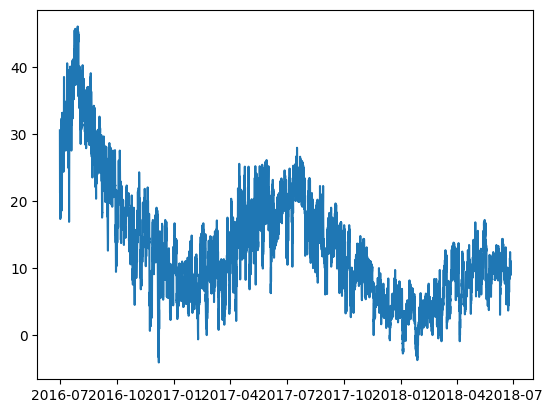

<ipython-input-2-7d446768cee6>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{value_col_name}(t-{i})'] = df[value_col_name].shift(i)


(17320, 101)
(17320, 100) (17320,)
(12124, 100) (3464, 100) (1732, 100)
(12124,) (3464,) (1732,)
(12124, 100, 1) (3464, 100, 1) (1732, 100, 1)
(12124, 1) (3464, 1) (1732, 1)
torch.Size([12124, 100, 1]) torch.Size([3464, 100, 1]) torch.Size([1732, 100, 1])
torch.Size([12124, 1]) torch.Size([3464, 1]) torch.Size([1732, 1])
torch.Size([512, 100, 1]) torch.Size([512, 1])


In [3]:
batch_size = 512
train_size,val_size,test_size = 0.7,0.2,0.1
lookback = 100
# date_col_name,value_col_name = 'Date','Close'
date_col_name,value_col_name = 'date','OT'
# csvPath = '/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/AMZN.csv'
csvPath = '/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/ETTh1.csv'
# csvPath = '~/Desktop/own-development-dsa5204-project/data/ETTh1.csv'
# csvPath = '/content/drive/MyDrive/dsa5204 project/ETTh1.csv'


data = pd.read_csv(csvPath)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

data = data[[date_col_name,value_col_name]]
data[date_col_name] = pd.to_datetime(data[date_col_name])
plt.plot(data[date_col_name], data[value_col_name])
plt.show()


shifted_df = prepare_dataframe_for_lstm(data, lookback, date_col_name, value_col_name)
shifted_df

# format X and y from df and scale it
shifted_df_as_np = shifted_df.to_numpy()
print(shifted_df_as_np.shape)

# normalise the data
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
print(X.shape, y.shape)
X = dc(np.flip(X, axis=1))

# train test split
X_train = X[:int(len(X) * train_size)]
X_val = X[int(len(X) * train_size):int(len(X) * train_size)+int(len(X) * val_size)]
X_test = X[int(len(X) * train_size)+int(len(X) * val_size):]

y_train = y[:int(len(y) * train_size)]
y_val = y[int(len(y) * train_size):int(len(y) * train_size)+int(len(y) * val_size)]
y_test = y[int(len(y) * train_size)+int(len(y) * val_size):]
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

X_train = X_train.reshape((-1, lookback, 1))
X_val = X_val.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))
y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

X_train = torch.tensor(X_train).float()
X_val = torch.tensor(X_val).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_val = torch.tensor(y_val).float()
y_test = torch.tensor(y_test).float()
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)


train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_val, y_val)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # set all shuffle=False since its sequential data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# print to check
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

# pretraining - model

In [4]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        original_pos_encoding = self.pe[:x.size(0), :]
        x = self.dropout(x + original_pos_encoding)
        return original_pos_encoding,x

try this idea, keep the positional encoding separate
issue is that the zeros are for everything but shud only be for the input time series and not positional encodings

In [5]:
# Model definition using Transformer

class MAETransformerModel(nn.Module):
    def __init__(self, masking_ratio=0.75, num_features=1, d_model=64, dropout=0.2, nhead=4, dim_feedforward=2048,num_layers=2):
        super(MAETransformerModel, self).__init__()

        self.masking_ratio = masking_ratio

        self.feature_projection = nn.Linear(num_features, d_model) # projects the input_num_features to d_model reqd for pos encoding
        self.positional_encoder = PositionalEncoding(d_model, dropout)

        transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)


        transformer_decoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout,batch_first=True
        )
        self.transformer_decoder = nn.TransformerEncoder(encoder_layer=transformer_encoder_layer, num_layers=num_layers)

        self.layer_norm1 = nn.LayerNorm(d_model)

        self.reverse_projection = nn.Linear(d_model,num_features) # projects the d_model to input_num_features to reconstruct the input X

    def get_latent_vector(self, x):
        # input x is in shape (batch_size,seq_length,num_features)

        features = self.feature_projection(x) # Token generation we generate a token for every input patch (by linear projection with an added positional embedding).
        original_pos_encoding,tokens = self.positional_encoder(features) # 512,100,63

        # Add input x to the first col of the positional encoding containing the original time series to maintain the original time series information
        # Extract the first slice of tokens (this will be of shape (512,100)) and reshape it to match the shape of input x (512,100,1)
        tokens_first_dim = tokens[:, :, 0].unsqueeze(-1)
        # Add input x to the first slice of tokens_first_dim
        tokens_first_dim += x

        # Extract the remaining slices of tokens
        tokens_rem = tokens[:, :, 1:]
        # Concatenate b_0th and b_rem along the last dimension
        tokens = torch.cat((tokens_first_dim, tokens_rem), dim=-1)

        # Random shuffling and masking
        shuffled_indices = torch.randperm(tokens.size(1)) # 1 as that is the sequence dimension
        num_unmasked = tokens.size(1)-int(self.masking_ratio * tokens.size(1))
        unmasked_indices = shuffled_indices[:num_unmasked]
        unmasked_tokens = tokens[:,unmasked_indices,:]

        # pass unmasked tokens to encoder
        encoded_tokens = self.transformer_encoder(unmasked_tokens)

        # get the masked tokens and mask them (set to zero)
        masked_indices = shuffled_indices[num_unmasked:]
        masked_tokens = tokens[:,masked_indices,:]
        masked_tokens[:,:,0] = 0. # only mask (set to 0) the first row

        # Appending mask tokens
        full_tokens = torch.cat((encoded_tokens, masked_tokens), dim=1)

        # Unshuffling and reconstructing the full vector
        unshuffled_indices = torch.argsort(shuffled_indices)
        latent_vector = full_tokens[:,unshuffled_indices,:] # unshuffled_full_tokens

        return original_pos_encoding,latent_vector,masked_indices

    def forward(self, x):

        original_pos_encoding,latent_vector,masked_indices = self.get_latent_vector(x)

        # add original position encodings again
        x = latent_vector + original_pos_encoding

        # pass to decoder
        x = self.transformer_decoder(x)
        x = self.layer_norm1(x)
        reconstructed = self.reverse_projection(x)
        # reconstructed = x[:,:,:1] # since we encoded the original time series information to the first col of the postional encoding vector

        # need to return the reconstructed and the masked indices, since the loss funciton should only calculate the loss on the masked patches
        return reconstructed,masked_indices


# # sample inference
# model = MAETransformerModel()
# for X,y in train_loader:
#     reconstructed,masked_indices = model(X)
#     break

# print(X.shape,reconstructed.shape)
# nn.MSELoss()(X[:,masked_indices,:],reconstructed[:,masked_indices,:])

# pretraining - train

In [6]:
# Train the model

masking_ratio = 0.75




print(f'masking_ratio: {masking_ratio}')
for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        reconstructed,masked_indices = model(x_batch)
        loss = criterion(reconstructed[:,masked_indices,:] , x_batch[:,masked_indices,:]) # must only calculate loss on masked patches
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            reconstructed,masked_indices = model(x_batch)
            loss = criterion(reconstructed[:,masked_indices,:] , x_batch[:,masked_indices,:]) # must only calculate loss on masked patches
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'MAE_pretraining_best_model.pt')
        print(f'model epoch {epoch} saved as pretraining_best_model.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

masking_ratio: 0.75
epoch 0
model epoch 0 saved as pretraining_best_model.pt
Epoch 1/1000, train loss: 0.5358, val loss: 0.4473, time_taken: 5.8
epoch 1
model epoch 1 saved as pretraining_best_model.pt
Epoch 2/1000, train loss: 0.1514, val loss: 0.1822, time_taken: 3.9
epoch 2
model epoch 2 saved as pretraining_best_model.pt
Epoch 3/1000, train loss: 0.2207, val loss: 0.0603, time_taken: 3.9
epoch 3
Epoch 4/1000, train loss: 0.2052, val loss: 0.1006, time_taken: 3.9
epoch 4
Epoch 5/1000, train loss: 0.1686, val loss: 0.1158, time_taken: 3.9
epoch 5
Epoch 6/1000, train loss: 0.1631, val loss: 0.0975, time_taken: 3.9
epoch 6
Epoch 7/1000, train loss: 0.1593, val loss: 0.0804, time_taken: 4.0
epoch 7
Epoch 8/1000, train loss: 0.1249, val loss: 0.1059, time_taken: 3.9
epoch 8
model epoch 8 saved as pretraining_best_model.pt
Epoch 9/1000, train loss: 0.1003, val loss: 0.0521, time_taken: 4.1
epoch 9
model epoch 9 saved as pretraining_best_model.pt
Epoch 10/1000, train loss: 0.0830, val loss

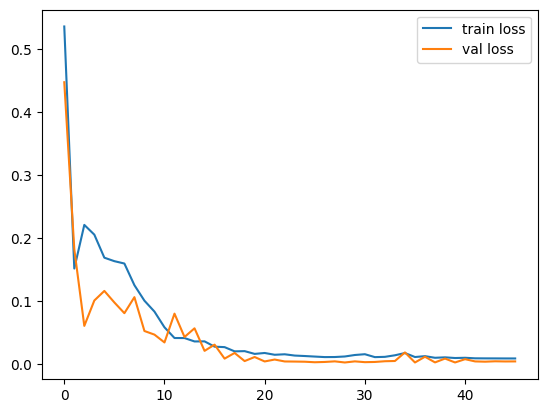

In [7]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.legend()
plt.show()

# pretraining - evaluate

only on masked indices
reconstruction_MSE_loss: 0.0919787585735321
reconstruction_MAE_loss: 0.20487330853939056

on full indices
reconstruction_MSE_loss: 0.18222784996032715
reconstruction_MAE_loss: 0.31301599740982056


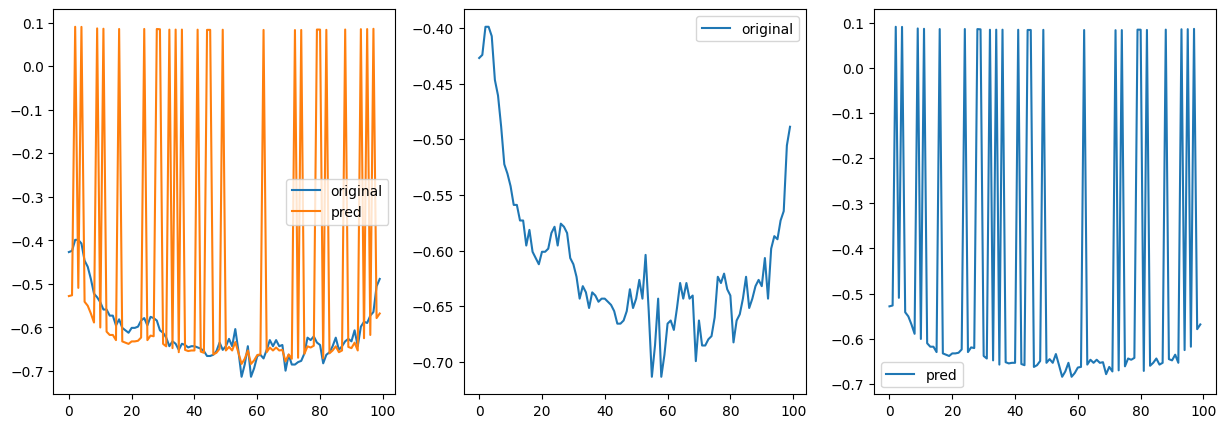

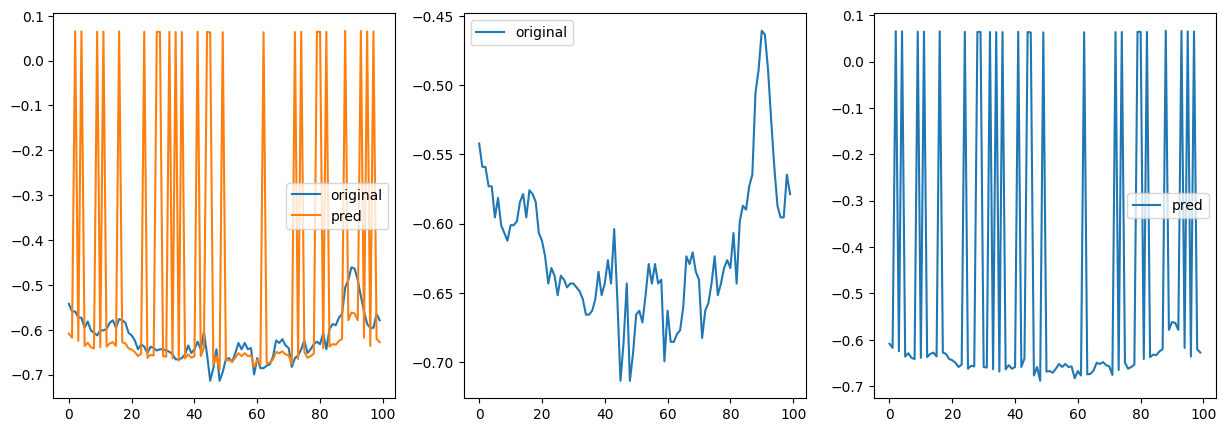

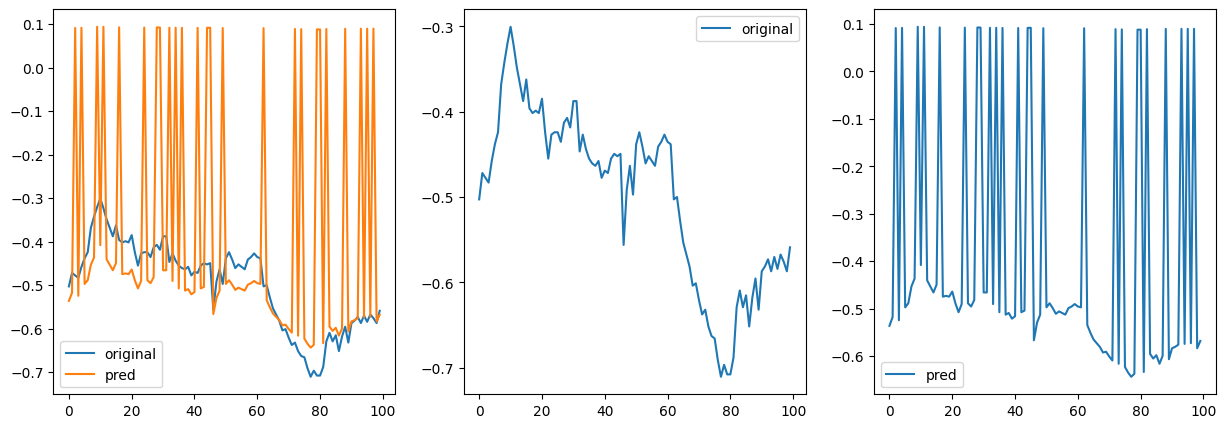

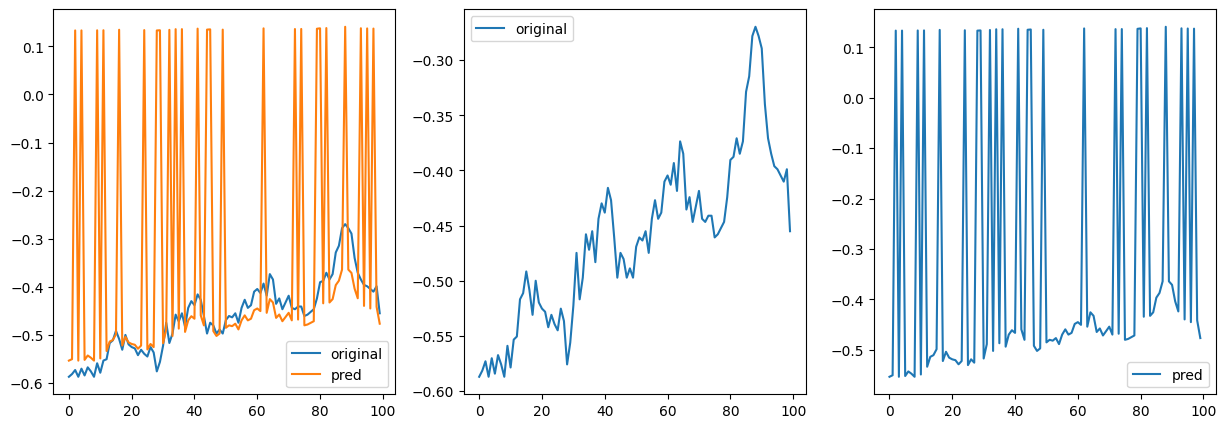

In [8]:
best_model_path = 'MAE_pretraining_best_model.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'


# Load the best model for evaluation
model = MAETransformerModel().to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()


reconstructed,masked_indices = model(X_test.to(device))

print('only on masked indices')
reconstruction_MSE_loss = nn.MSELoss()(reconstructed.cpu().detach()[:,masked_indices,:],X_test.cpu().detach()[:,masked_indices,:])
reconstruction_MAE_loss = nn.L1Loss()(reconstructed.cpu().detach()[:,masked_indices,:],X_test.cpu().detach()[:,masked_indices,:])
print(f'reconstruction_MSE_loss: {reconstruction_MSE_loss}')
print(f'reconstruction_MAE_loss: {reconstruction_MAE_loss}')

print()
print('on full indices')
reconstruction_MSE_loss = nn.MSELoss()(reconstructed.cpu().detach(),X_test.cpu().detach())
reconstruction_MAE_loss = nn.L1Loss()(reconstructed.cpu().detach(),X_test.cpu().detach())
print(f'reconstruction_MSE_loss: {reconstruction_MSE_loss}')
print(f'reconstruction_MAE_loss: {reconstruction_MAE_loss}')

# plot reconstruction

indices = [0,10,210,300]
reconstructed = reconstructed.cpu().detach()
X_test = X_test.cpu().detach()

for index in indices:
  fig,ax = plt.subplots(1,3,figsize=(15,5))
  reconstructed_ = reconstructed[index]
  X_test_ = X_test[index]

  plt.subplot(1,3,1)
  plt.plot(X_test_,label='original')
  plt.plot(reconstructed_,label='pred')
  plt.legend()

  plt.subplot(1,3,2)
  plt.plot(X_test_,label='original')
  plt.legend()

  plt.subplot(1,3,3)
  plt.plot(reconstructed_,label='pred')
  plt.legend()

  plt.show()

# finetuning - model

In [9]:
# Model definition using Transformer

import torch.nn.functional as F

class FinetuningTransformerModel(nn.Module):
    def __init__(self, d_model=64, num_features=1, seq_len=100, forecasting_window=1):
      super(FinetuningTransformerModel, self).__init__()

      self.seq_len = seq_len
      self.linear1 = nn.Linear(d_model,num_features)
      self.layer_norm = nn.LayerNorm(seq_len)
      self.linear2 = nn.Linear(seq_len,1)
      # self.linear3 = nn.Linear(64,1)
      # self.linear3 = nn.Linear(seq_len,1)


    def forward(self, x):
      # input x is the latent vector from the pretraining model latent vector output

      x = F.tanh(self.linear1(x))
      x = x.view(x.size(0), -1) # flatten
      x = self.layer_norm(x)
      # x = F.relu(self.linear1(x))
      x = self.linear2(x) #apply tanh if the values go beyond (-1,1)

      # x = F.relu(self.linear1(x))
      # x = x.view(x.size(0),self.seq_len)
      # # x = F.relu(self.linear2(x))
      # x = self.linear3(x)
      # x = self.linear1(x[:,-1,:])
      # x = F.relu(self.linear1(x))
      # x = x.view(x.size(0),self.seq_len)
      # x = self.linear2(x)
      # x = x[:,:,:1] # since we encoded the original time series information to the first col of the postional encoding vector
      # x = x.view(x.size(0),self.seq_len)
      # x = F.relu(self.linear2(x))
      # x = self.linear3(x)

      return x

In [10]:
# # sample inference

# # model = MAETransformerModel(masking_ratio=0.)
# for X,y in train_loader:
#     latent_vector,masked_indices = model.cpu().get_latent_vector(X)
#     break

# print(X.shape,latent_vector.shape)

# nn.MSELoss()(X,latent_vector)

# model2 = FinetuningTransformerModel()

# model2(latent_vector.cpu()).shape,y.shape

# finetuning - train

In [12]:
# Train the model

from torch.optim.lr_scheduler import ReduceLROnPlateau

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
criterion = nn.MSELoss()

# load best pretraining model
best_model_path = 'MAE_pretraining_best_model.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
pretraining_model = MAETransformerModel(masking_ratio=0.).to(device)
pretraining_model.load_state_dict(torch.load(best_model_path,map_location=device))
pretraining_model.eval()

# intialise finetuning model for forecasting task
model = FinetuningTransformerModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

train_losses=[]
val_losses=[]


for epoch in range(epochs):
    epoch_start_time = time.time()
    print(f'epoch {epoch}')
    model.train()

    train_running_loss = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        _,latent_vector,_ = pretraining_model.get_latent_vector(x_batch)

        optimizer.zero_grad()
        outputs = model(latent_vector)

        loss = criterion(outputs, y_batch)
        train_running_loss.append(loss.item())
        loss.backward()
        optimizer.step()

    train_loss = np.mean(train_running_loss)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_running_loss = []
    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            _,latent_vector,_ = pretraining_model.get_latent_vector(x_batch)

            outputs = model(latent_vector)

            loss = criterion(outputs, y_batch)
            val_running_loss.append(loss.item())

    val_loss = np.mean(val_running_loss)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        torch.save(model.state_dict(), 'finetuning_best_model_2.pt')
        print(f'model epoch {epoch} saved as finetuning_best_model_2.pt')
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 10:
        print("Early stopping!")
        break

    time_taken = round(time.time()-epoch_start_time,1)
    print(f"Epoch {epoch + 1}/{epochs}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}, time_taken: {time_taken}")

cuda
epoch 0
model epoch 0 saved as finetuning_best_model_2.pt
Epoch 1/1000, train loss: 0.1860, val loss: 0.5155, time_taken: 3.4
epoch 1
model epoch 1 saved as finetuning_best_model_2.pt
Epoch 2/1000, train loss: 0.1419, val loss: 0.4064, time_taken: 2.7
epoch 2
model epoch 2 saved as finetuning_best_model_2.pt
Epoch 3/1000, train loss: 0.1161, val loss: 0.3169, time_taken: 2.7
epoch 3
model epoch 3 saved as finetuning_best_model_2.pt
Epoch 4/1000, train loss: 0.1064, val loss: 0.2619, time_taken: 2.7
epoch 4
model epoch 4 saved as finetuning_best_model_2.pt
Epoch 5/1000, train loss: 0.1061, val loss: 0.2400, time_taken: 2.7
epoch 5
model epoch 5 saved as finetuning_best_model_2.pt
Epoch 6/1000, train loss: 0.1070, val loss: 0.2347, time_taken: 2.8
epoch 6
model epoch 6 saved as finetuning_best_model_2.pt
Epoch 7/1000, train loss: 0.1071, val loss: 0.2342, time_taken: 2.7
epoch 7
Epoch 8/1000, train loss: 0.1069, val loss: 0.2345, time_taken: 2.8
epoch 8
Epoch 9/1000, train loss: 0.1

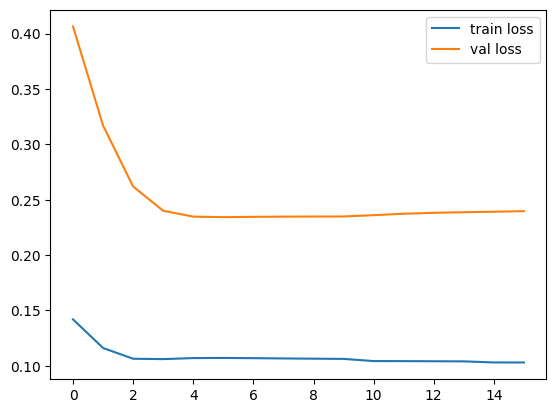

In [13]:
# plot train val loss curves

import matplotlib.pyplot as plt

plt.plot(train_losses[1:],label='train loss')
plt.plot(val_losses[1:],label='val loss')
plt.legend()
plt.show()

# finetuning - evaluate

forecast_MSE_loss: 0.0740155279636383
forecast_MAE_loss: 0.2606738209724426
torch.Size([1732, 1]) torch.Size([1732, 1])


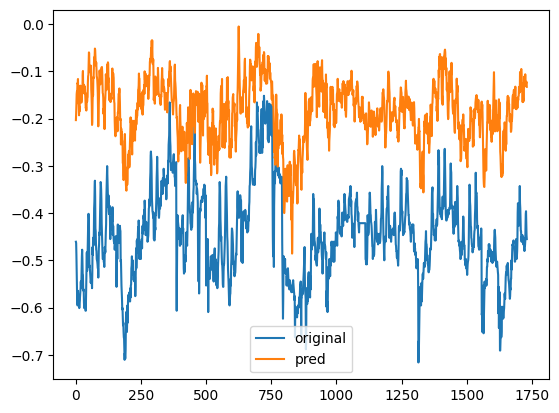

In [15]:
# load best pretraining model
best_model_path = 'MAE_pretraining_best_model.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
pretraining_model = MAETransformerModel(masking_ratio=0.).to(device)
pretraining_model.load_state_dict(torch.load(best_model_path,map_location=device))
pretraining_model.eval()

# load best pretraining model
best_model_path = 'finetuning_best_model_2.pt'
# best_model_path = f'/content/drive/MyDrive/uni acads/MASTERS/y1s2/dsa5204/weights/{best_model_path}'
finetuning_model = FinetuningTransformerModel().to(device)
finetuning_model.load_state_dict(torch.load(best_model_path,map_location=device))
finetuning_model.eval()

_,latent_vector,_ = pretraining_model.get_latent_vector(X_test.to(device))
predictions = finetuning_model(latent_vector)
forecast_MSE_loss = nn.MSELoss()(predictions.cpu().detach(),y_test.cpu().detach())
print(f'forecast_MSE_loss: {forecast_MSE_loss}')
forecast_MAE_loss = nn.L1Loss()(predictions.cpu().detach(),y_test.cpu().detach())
print(f'forecast_MAE_loss: {forecast_MAE_loss}')
print(predictions.shape,y_test.shape)

# plot forecasting prediction

y = y_test.cpu().detach()
pred = predictions.cpu().detach()

plt.plot(y,label='original')
plt.plot(pred,label='pred')
plt.legend()

plt.show()